In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

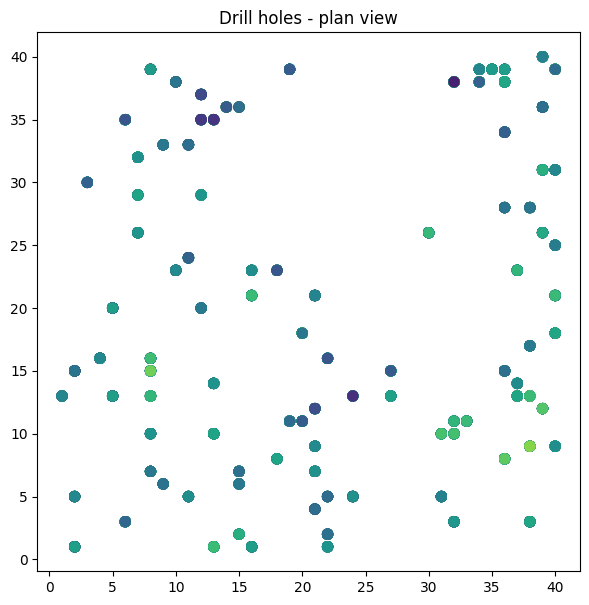

In [24]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 100

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])



fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### Adding some random points from the block

In [25]:
df_simulation_sample = pd.concat([df_simulation_sample, df_simulation.sample(1000)])
df_simulation_sample.drop_duplicates(inplace=True)
df_simulation_sample

,x,y,z,finos,litho,alter
18360,12.0,20.0,1.0,3.133878,Litho_B,Alter_B
18361,12.0,20.0,2.0,3.312070,Litho_B,Alter_C
18362,12.0,20.0,3.0,4.411989,Litho_B,Alter_C
18363,12.0,20.0,4.0,4.599849,Litho_B,Alter_C
18364,12.0,20.0,5.0,3.747072,Litho_B,Alter_C
...,...,...,...,...,...,...
43578,28.0,10.0,19.0,4.721357,Litho_B,Alter_D
2352,2.0,19.0,33.0,3.866651,Litho_A,Alter_D
3234,3.0,1.0,35.0,4.079269,Litho_A,Alter_A
26091,17.0,13.0,12.0,4.595775,Litho_C,Alter_D


### Creating a Multilayer perceptron to make predictions

#### Create Training Dataset

In [26]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

### Using Pytorch

In [27]:
# Define la clase de la red neuronal
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, int(hidden_size/2))
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(hidden_size/2), hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        # self.fc4 = nn.Linear(2*hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        return out

class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=50)
val_loader = data.DataLoader(val, batch_size=50)
real_loader = data.DataLoader(real)

input_size = X.shape[1]  # 3 coordenadas XYZ y n_litologies litologías
hidden_size = 32
output_size = 1  # Ley mineral del yacimiento

# Inicializa la red neuronal
model = MineralPredictionNet(input_size, hidden_size, output_size)
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Repite el proceso de entrenamiento y validación varias veces
epochs = 50
loss_list=[]
val_list = []
for epoch in range(epochs):
    # Itera a través de los datos de entrenamiento
    running_loss = 0
    running_val = 0
    for x, y in train_loader:
        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
    loss_list.append(running_loss)

    # Itera a través de los datos de validación
    for x,y in val_loader:
        # Convierte los datos a tensores de PyTorch

        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()

        # Calcula la pérdida
        val = criterion(y_pred, y)
        running_val = running_val + val.item()
    val_list.append(running_val)
    
      # display statistics
    print(f'epoch {epoch + 1}, loss {running_loss:f}')
    print(f'epoch {epoch + 1}, val {running_val:f}')

epoch 1, loss 50.983549
epoch 1, val 3.017488
epoch 2, loss 5.053781
epoch 2, val 0.594258
epoch 3, loss 1.748888
epoch 3, val 0.282245
epoch 4, loss 0.992190
epoch 4, val 0.185234
epoch 5, loss 0.701457
epoch 5, val 0.139037
epoch 6, loss 0.534298
epoch 6, val 0.107893
epoch 7, loss 0.417738
epoch 7, val 0.084155
epoch 8, loss 0.332991
epoch 8, val 0.067275
epoch 9, loss 0.272661
epoch 9, val 0.054872
epoch 10, loss 0.227371
epoch 10, val 0.045637
epoch 11, loss 0.191246
epoch 11, val 0.038857
epoch 12, loss 0.162983
epoch 12, val 0.033904
epoch 13, loss 0.141049
epoch 13, val 0.030206
epoch 14, loss 0.123782
epoch 14, val 0.027208
epoch 15, loss 0.109849
epoch 15, val 0.024727
epoch 16, loss 0.098527
epoch 16, val 0.022671
epoch 17, loss 0.089008
epoch 17, val 0.020875
epoch 18, loss 0.081028
epoch 18, val 0.019264
epoch 19, loss 0.074238
epoch 19, val 0.017928
epoch 20, loss 0.068390
epoch 20, val 0.016673
epoch 21, loss 0.063114
epoch 21, val 0.015571
epoch 22, loss 0.058425
epoch 

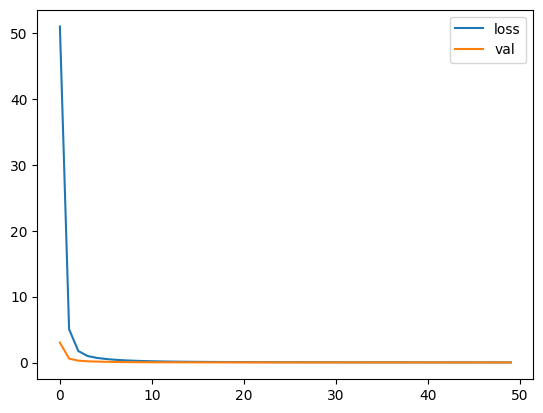

In [30]:
plt.plot(loss_list, label='loss')
plt.plot(val_list, label='val')
plt.legend()

r2:  -19.46674571310033
mae:  4.369704770195298
mape:  117578471048.1656


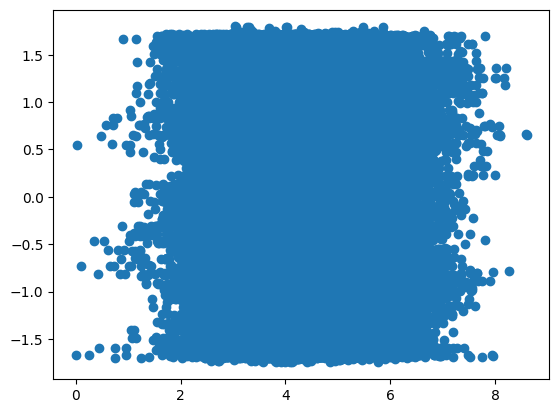

In [35]:
y_pred = []
y_real = []
for x,y in real_loader:
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

### Using Tensorflow

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def build_model():
    input_layer = layers.Input(shape=(X_train.shape[1],), name='input')
    first_dense = layers.Dense(units=25, activation='relu')(input_layer)
    second_dense = layers.Dense(units=625, activation='relu')(first_dense)
    third_dense = layers.Dense(units=1250, activation='relu')(second_dense)
    output = layers.Dense(units=1, name='out')(third_dense)

    return Model(inputs=input_layer, outputs=output)

model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tf.keras.metrics.MeanSquaredError(),
              )
model.summary()

2023-01-01 16:34:22.746054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 16:34:24.639005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/lib/:/lib/
2023-01-01 16:34:24.639078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/lib/:/lib/
2023-01-01 16:34:24.639083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT W

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 25)                275       
                                                                 
 dense_1 (Dense)             (None, 625)               16250     
                                                                 
 dense_2 (Dense)             (None, 1250)              782500    
                                                                 
 out (Dense)                 (None, 1)                 1251      
                                                                 
Total params: 800,276
Trainable params: 800,276
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train the model for 200 epochs
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/50


2023-01-01 16:34:48.245896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-01 16:34:48.382991: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8ae288a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-01 16:34:48.383025: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-01-01 16:34:48.415973: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-01 16:34:48.749580: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 2s 5ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 2/50
96/96 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/50
96/96 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/50
96/96 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
96/96 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.2320e-04 - val_mean_squared_error: 9.2320e-04
Epoch 6/50
96/96 [==============================] - 0s 2ms/step - loss: 7.5938e-04 - mean_squared_error: 7.5938e-04 - val_loss: 7.5169e-04 - val_mean_squared_error: 7.5169e-04
Epoch 7/50
96/96 [=========

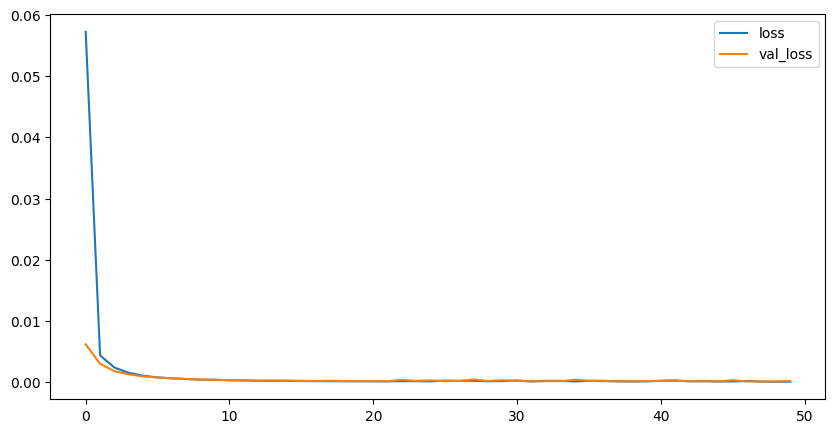

In [12]:
fig, axs = plt.subplots()
fig.set_size_inches(10,5)
axs.plot(history.history['loss'], label="loss")
axs.plot(history.history['val_loss'], label="val_loss")
axs.legend()

2000/2000 [==============================] - 1s 692us/step
r2:  -19.45472667656443
mae:  4.367846253632992
mape:  118208119964.64519


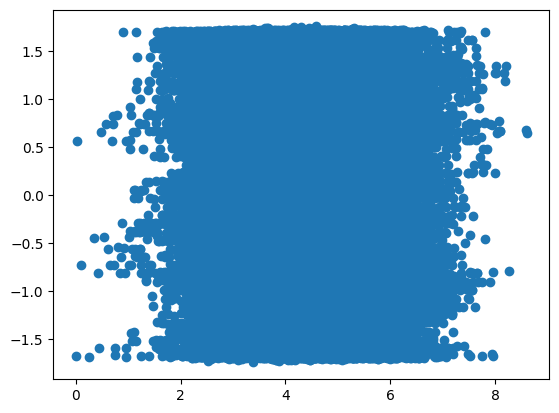

In [13]:
y_pred = model.predict(df.iloc[:,:-1])
y_real = df.iloc[:,-1]
print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)